In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import metrics
import collection
import seaborn as sns

In [3]:
obs=pd.read_csv('../data/box_samples_total.csv',index_col=0)
obs.describe(include='all')

/Users/terry/GNSS/.venv/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,x,y,w,z,a,b,d_ray,d_building,az,el,time
count,1.173628e+07,1.173628e+07,815950.000000,815950.000000,815950.000000,815950.000000,815950.000000,1.173628e+07,815950.000000,1.173628e+07,11736284
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,297005
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 01:45:13.049472423
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49
mean,5.280000e+05,1.830001e+05,19.240882,23.702506,527999.824319,182999.611326,27.016147,3.223095e+01,170.220103,2.925803e+01,NaN
std,2.899120e+01,2.899982e+01,11.020517,41.980056,4.149538,3.993823,16.132895,1.367070e+01,106.214906,2.219990e+01,NaN
min,5.279500e+05,1.829500e+05,0.000033,1.000010,527995.000000,182995.000000,0.000504,5.011397e-04,0.000426,1.587565e-05,NaN
25%,5.279748e+05,1.829749e+05,10.046013,4.056403,527995.000000,182995.000000,13.258976,2.237134e+01,63.476517,1.051647e+01,NaN
50%,5.280000e+05,1.830000e+05,19.243077,10.599973,527999.630868,182999.272302,26.599299,3.376414e+01,162.308456,2.418964e+01,NaN
75%,5.280252e+05,1.830253e+05,28.030802,25.434645,528004.973326,183003.956813,39.883373,4.265357e+01,277.588176,4.468462e+01,NaN


In [5]:
print(metrics.int_metric(obs.z,10,np.inf))
print(metrics.int_metric(obs.z,10,np.inf)/obs.shape[0])
print(metrics.int_metric(obs.z,10,8))
print(metrics.int_metric(obs.z,10,8)/obs.shape[0])
print(metrics.int_metric(obs.z,10,1))
print(metrics.int_metric(obs.z,10,1)/obs.shape[0])

815950
0.06952370954895093
444136
0.03784298334975534
46735
0.003982095184472359


10 million obs give 500k that intersect, and 116k with an I_4 metric

In [6]:
bounds=[np.floor(obs.x.min()),np.floor(obs.y.min()),np.ceil(obs.x.max()-1e-3),np.ceil(obs.y.max())]

In [7]:
bounds

[527950.0, 182949.0, 528050.0, 183050.0]

In [8]:
observations_plot=collection.create_image(obs.x,obs.y,np.ones_like(obs.x),0.5,bounds,mean=False)
np.nanmean(observations_plot)/np.nanstd(observations_plot)

6.7268848634769505

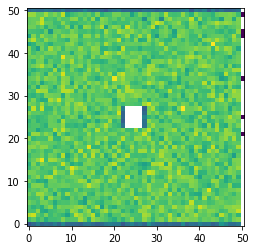

In [19]:
plt.imshow(observations_plot,origin='lower')

In [10]:
pd.DataFrame(observations_plot.flatten()).describe()

,0
count,2536.00000
mean,4627.87224
std,688.10230
min,38.00000
25%,4398.00000
50%,4704.00000
75%,5018.00000
max,6345.00000


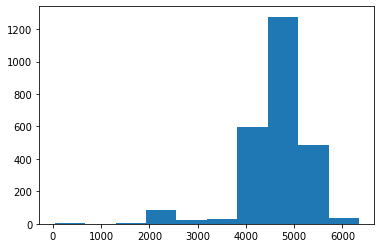

In [11]:
plt.hist(observations_plot.flatten())
plt.show()

Normally distributed number of observations in each cell

In [12]:
intersection_plot=collection.create_image(obs.x,obs.y,~obs.z.isna(),0.5,bounds,mean=True)

In [13]:
pd.DataFrame(intersection_plot.flatten()).describe()

,0
count,2536.000000
mean,0.069335
std,0.058752
min,0.000000
25%,0.036358
50%,0.052249
75%,0.079618
max,0.513475


<AxesSubplot:ylabel='Count'>

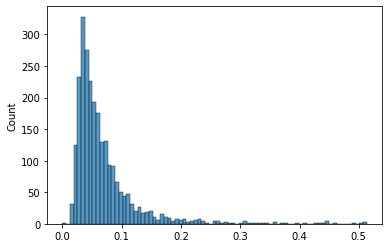

In [14]:
sns.histplot(intersection_plot.flatten())

/Users/terry/GNSS/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Count'>

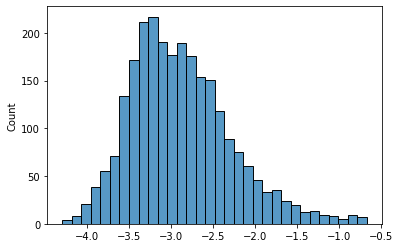

In [15]:
a=np.log(intersection_plot)
a=np.ma.masked_invalid(a)
sns.histplot(a.flatten())

lognormal distribution of intersection

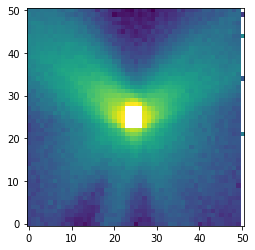

In [20]:
plt.imshow(a,origin='lower')

Spatial correlation of observation effectiveness. Being closer is better. Directly North is bad, but NE and NW is good.

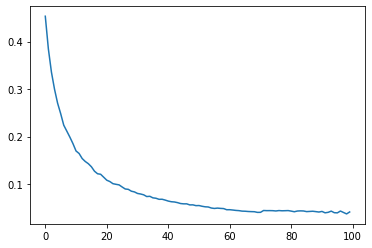

In [21]:
plt.plot((1-obs.z.isna()).groupby(pd.cut(obs.d_building,100)).mean())

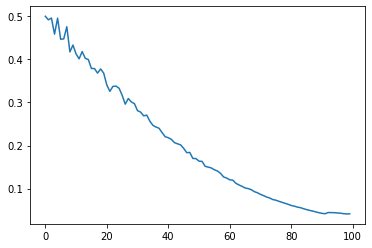

In [22]:
plt.plot((1-obs.z.isna()).groupby(pd.cut(np.log(1+obs.d_building),100)).mean())

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
obs['i']=1-obs.z.isna()
obs

,x,y,w,z,a,b,d_ray,d_building,az,el,time,i
0,528045.438029,182972.941857,NaN,NaN,NaN,NaN,NaN,46.062955,NaN,16.243254,2021-01-01 11:46:37.052396169,0
1,528045.438029,182972.941857,NaN,NaN,NaN,NaN,NaN,46.062955,NaN,31.001096,2021-01-01 11:46:37.052396169,0
2,528045.438029,182972.941857,NaN,NaN,NaN,NaN,NaN,46.062955,NaN,4.438707,2021-01-01 11:46:37.052396169,0
3,528045.438029,182972.941857,NaN,NaN,NaN,NaN,NaN,46.062955,NaN,28.132328,2021-01-01 11:46:37.052396169,0
4,528045.438029,182972.941857,NaN,NaN,NaN,NaN,NaN,46.062955,NaN,35.559313,2021-01-01 11:46:37.052396169,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3911690,528036.799188,182977.440725,NaN,NaN,NaN,NaN,NaN,36.325149,NaN,5.824014,2021-01-01 19:35:25.968923312,0
3911691,528036.799188,182977.440725,NaN,NaN,NaN,NaN,NaN,36.325149,NaN,18.716342,2021-01-01 19:35:25.968923312,0
3911692,528036.799188,182977.440725,NaN,NaN,NaN,NaN,NaN,36.325149,NaN,47.342647,2021-01-01 19:35:25.968923312,0
3911693,528036.799188,182977.440725,NaN,NaN,NaN,NaN,NaN,36.325149,NaN,34.998305,2021-01-01 19:35:25.968923312,0


In [26]:
m2=smf.glm('i ~ I(np.log(1+d_building))',data =obs,family=sm.families.Binomial()).fit()
print(m2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      i   No. Observations:             11736284
Model:                            GLM   Df Residuals:                 11736282
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.8097e+06
Date:                Wed, 21 Jul 2021   Deviance:                   5.6193e+06
Time:                        21:37:38   Pearson chi2:                 1.18e+07
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [27]:
p=obs.i.groupby(pd.cut(np.log(1+obs.d_building),100,include_lowest=True)).mean()
odds=p/(1-p)
odds

d_building
(-0.0046700000000000005, 0.0422]    1.001934
(0.0422, 0.0838]                    0.969398
(0.0838, 0.126]                     0.985261
(0.126, 0.167]                      0.848048
(0.167, 0.209]                      0.984000
                                      ...   
(3.959, 4.001]                      0.045200
(4.001, 4.043]                      0.044566
(4.043, 4.084]                      0.043357
(4.084, 4.126]                      0.042743
(4.126, 4.168]                      0.042849
Name: i, Length: 100, dtype: float64

In [28]:
y=np.exp(m2.params[0]+ m2.params[1]*(odds.index.categories.mid))
p=y/(1+y)
log_predicts=pd.DataFrame({"x":np.exp(odds.index.categories.mid)-1,"y":y,"p":p})
log_predicts

,x,y,p
0,0.018942,1.119525,0.528196
1,0.065027,1.078406,0.518862
2,0.110600,1.040851,0.510008
3,0.157775,1.004858,0.501212
4,0.206834,0.970192,0.492435
...,...,...,...
95,52.517034,0.039237,0.037756
96,54.812620,0.037867,0.036486
97,57.177577,0.036561,0.035271
98,59.642745,0.035300,0.034096


In [29]:
(odds/(1+odds))

d_building
(-0.0046700000000000005, 0.0422]    0.500483
(0.0422, 0.0838]                    0.492231
(0.0838, 0.126]                     0.496288
(0.126, 0.167]                      0.458888
(0.167, 0.209]                      0.495968
                                      ...   
(3.959, 4.001]                      0.043246
(4.001, 4.043]                      0.042665
(4.043, 4.084]                      0.041555
(4.084, 4.126]                      0.040991
(4.126, 4.168]                      0.041088
Name: i, Length: 100, dtype: float64

/Users/terry/GNSS/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


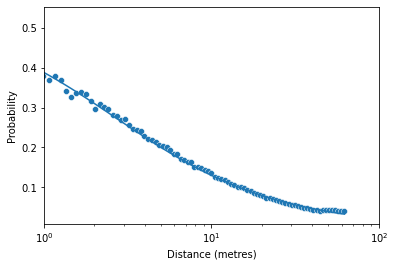

In [30]:
a= sns.scatterplot(np.exp(odds.index.categories.mid)-1,odds/(1+odds))
sns.lineplot(x='x',y='p',data=log_predicts,ax=a)
# plt.yscale('log')
plt.xscale('log')
plt.xlim(1,100)
plt.ylabel('Probability')
plt.xlabel('Distance (metres)')
plt.savefig('../figures/distance_regression.png')


In [31]:
intersection_residuals_plot=collection.create_image(obs.x.round(0),obs.y.round(0),obs.i-m2.fittedvalues,1,bounds,mean=True)

In [32]:
pd.DataFrame(intersection_residuals_plot.flatten()).describe()

,0
count,10120.000000
mean,-0.000052
std,0.028266
min,-0.180608
25%,-0.016575
50%,-0.007105
75%,0.014963
max,0.155381


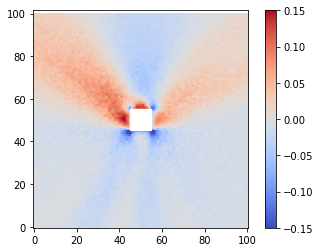

In [33]:
a=plt.imshow(intersection_residuals_plot,cmap='coolwarm',vmin=-0.15,vmax=0.15,origin='lower')
plt.colorbar(a)
plt.savefig('../figures/distance_residuals.png')

We also need to consider the effect of building height.


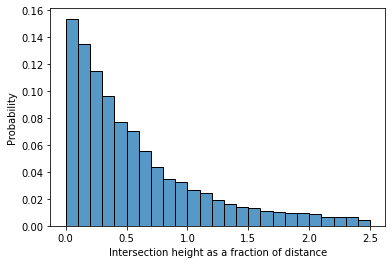

In [34]:
sns.histplot(np.tan(np.deg2rad(obs.el)),stat='probability',bins=25,binrange=(0,2.5))
plt.xlabel('Intersection height as a fraction of distance')
plt.savefig('../figures/elevation.png')

In [35]:
from metrics import _indicator as indicator

In [36]:
cuts_=pd.cut(obs.d_building,100)

In [37]:
indicators = []
for i,h in enumerate([5,10,20,40]):
    for j,m in enumerate([1,4,8,np.inf]):
        df=pd.DataFrame({'Height':h,'Metric':m, 'Distance': cuts_.cat.categories.mid, "Proportion": indicator(obs.z,h,m).astype('int').groupby(cuts_).mean()})
        indicators.append(df)
indicators=pd.concat([i.reset_index() for i in indicators])
indicators.Height=indicators.Height.astype('category')
indicators.Metric=indicators.Metric.astype('category')

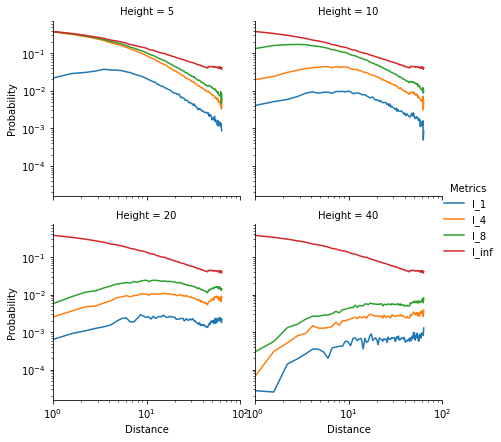

In [41]:
g=sns.FacetGrid(indicators,col='Height',col_wrap=2,sharex=True,sharey=True,legend_out=True)
g=g.map_dataframe(sns.lineplot,x='Distance',y='Proportion',hue='Metric').add_legend()
g._legend.set_title('Metrics')
new_labels = ['I_1', 'I_4','I_8', 'I_inf']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.xscale('log')
plt.xlim(1,100)
plt.yscale('log')
g.set_ylabels('Probability')
g.set_xlabels('Distance')
# plt.legend()
plt.savefig('../figures/height_metrics.png')

In [ ]:
fig,axes=plt.subplots(ncols=4,figsize=(12,4))
for i,h in enumerate([10,20,30,40]):
    axes[i].imshow(collection.create_image(obs.x,obs.y,indicator(obs.z,h,4).astype('int'),0.25,bounds,mean=False)/(i_count+0.01),vmin=0,vmax=0.35)

In [ ]:
fig,axes=plt.subplots(ncols=4,figsize=(12,4))
for i,h in enumerate([10,20,30,40]):
    axes[i].imshow(collection.create_image(obs.x,obs.y,indicator(obs.z,h,4).astype('int'),0.5,bounds,mean=True),vmin=0,vmax=0.01)

In [46]:
obs.time.describe(datetime_is_numeric=True)

count                          11736284
unique                           297005
top       2021-01-01 01:46:38.611543163
freq                                 49
Name: time, dtype: object

In [10]:
obs.dtypes

x             float64
y             float64
w             float64
z             float64
a             float64
b             float64
d_ray         float64
d_building    float64
az            float64
el            float64
time           object
i               int64
dtype: object

In [11]:
timerange=pd.date_range('2021-01-01',freq='15min',periods =97)
time_bin=pd.cut(pd.to_datetime(obs.time),timerange)

In [16]:
.describe()

count    96.000000
mean      0.069556
std       0.002583
min       0.064274
25%       0.067626
50%       0.069435
75%       0.071323
max       0.075739
Name: i, dtype: float64